In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
from matplotlib import patches
import seaborn as sns
%matplotlib notebook

In [ ]:
from objective_function import *
from optimiser import *

In [258]:
optimal, optimum, statistics = cma.optimise(ak)
if np.linalg.norm(optimal - ak.get_optimal()) < 1e-1 \
or np.linalg.norm(optimum - ak.get_optimum()) < 1e-1:
    statistics['status'] = 'global minimum'
elif statistics['status'] != 'diverge':
    statistics['status'] = 'local minimum'
print(statistics['status'])

*******starting optimisation from intitial mean:  [52.743 12.21 ]
eigenvalue of variance = [0.19810038 0.10375055]
total iterations = 94, total evaluatios = 564
found minimum position = [39.99981952 12.00003368], found minimum = 19.94553464542604
local minimum


In [324]:
import numpy as np
from abc import ABC, abstractmethod

class optimizer(ABC):
    @abstractmethod
    def set_parameters(self, para):
        '''
        input: parameters, in dictionary
        '''
        pass
    @abstractmethod
    def optimise(self, objective_cls):
        '''
        input: objective function class
        output: empirical found optimal, optimum, and statistics of procedure information
        '''
        pass
    
class adjust_optimizer(optimizer):
    def adjust(self, x0, obj):
        self.x0 = x0
        return self.optimise(obj)
    
class cma_es(optimizer):
    def set_parameters(self, paras):
        self.mean0 = paras['mean0'] 
        self.std = paras['std']
        self.tol = paras['tol']
        self.adjust_func = paras['adjust_func']
        self.max_iter = 400
        # set none to use default value 
        self.cluster_size = None if 'cluster_size' not in paras.keys() else paras['cluster_size']
        self.survival_size = None if 'survival_size' not in paras.keys() else paras['survival_size']
        self.record = True if 'multi_runs' not in paras.keys() else paras['multi_runs']
    def optimise(self, obj):
        '''
        @param obj: objective function class instance
        return arg: found minimum arguments
               val: found minimum value
               stats: collection of recorded statistics for post-analysis
        '''                  
        def update_mean(x):
            return (weights @ x).reshape(dim, 1)
        def update_ps(ps, sigma, C, mean, mean_old):
            return (1 - cs) * ps + np.sqrt(cs * (2 - cs) * mueff) * invsqrtC @ (mean - mean_old) / sigma 
        def update_pc(pc, sigma, ps, mean, mean_old):
            hsig = np.abs(ps) / np.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < 1.4 + 2/(dim + 1)
            return (1 - cc) * pc + hsig * np.sqrt(cc * (2 - cc) * mueff) * (mean - mean_old) / sigma
        def update_C(C, pc, x, mean_old, sigma):
            hsig = np.abs(ps) / np.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < 1.4 + 2/(dim + 1)
            artmp = (1 / sigma) * (x - mean_old.reshape(1, dim))
            return (1 - c1 - cmu) * C + c1 * (pc * pc.T + (1 - hsig) * cc * (2 - cc) * C) + cmu * artmp.T @ np.diag(weights) @ artmp
        def update_sigma(sigma, ps):
            return sigma * np.exp((cs / damps) * (np.linalg.norm(ps)/ chiN - 1))
        def not_moving(stats, tol):
            dis_arg = np.linalg.norm(stats['arg'][-1] - stats['arg'][-2])
            dis_val = np.linalg.norm(stats['val'][-1] - stats['val'][-2])
            return (dis_arg < tol and dis_val < tol*1e5) or (dis_val < tol and dis_arg < tol*1e5) 

        print("*******starting optimisation from intitial mean: ", self.mean0.ravel())
        # User defined input parameters 
        dim = 2    
        sigma = 0.3
        D = self.std / sigma
        mean = self.mean0

        # the size of solutions group
        lambda_ = 4 + int(3 * np.log(dim)) if self.cluster_size == None else self.cluster_size  
        # only best "mu" solutions are used to generate iterations
        mu = int(lambda_ / 2) if self.survival_size == None else self.survival_size
        # used to combine best "mu" solutions                                               
        weights = np.log(mu + 1/2) - np.log(np.arange(mu) + 1) 
        weights = weights / np.sum(weights)     
        mueff = np.sum(weights)**2 / np.sum(weights**2) 

        # Strategy parameter setting: Adaptation
        # time constant for cumulation for C
        cc = (4 + mueff / dim) / (dim + 4 + 2 * mueff / dim)  
        # t-const for cumulation for sigma control
        cs = (mueff + 2) / (dim + mueff + 5)  
        # learning rate for rank-one update of C
        c1 = 2 / ((dim + 1.3)**2 + mueff)    
        # and for rank-mu update
        cmu = min(1 - c1, 2 * (mueff - 2 + 1 / mueff) / ((dim + 2)**2 + mueff))  
        # damping for sigma, usually close to 1  
        damps = 1 + 2 * max(0, np.sqrt((mueff - 1)/( dim + 1)) - 1) + cs                                                                 

        # Initialize dynamic (internal) strategy parameters and constants
        # evolution paths for C and sigma
        pc = np.zeros((dim, 1))     
        ps = np.zeros((dim, 1)) 
        # B defines the coordinate system
        B = np.eye(dim)       
        # covariance matrix C
        C = B * np.diag(D**2) * B.T 
        # C^-1/2 
        invsqrtC = B * np.diag(D**-1) * B.T   
        # expectation of ||N(0,I)|| == norm(randn(N,1)) 
        chiN = dim**0.5 * (1 - 1/(4 * dim) + 1 / (21 * dim**2))  

        # --------------------  Initialization --------------------------------  
        x, x_old, f = np.zeros((lambda_, dim)), np.zeros((lambda_, dim)), np.zeros((lambda_,))
        stats = {}
        stats['val'], stats['arg'] = [], []
        stats['x_adjust'] = []
        iter_eval, stats['evals_per_iter'] = np.zeros((lambda_, )), []
        stats['mean'], stats['std'] = [], []
        stats['status'] = None
        iter_, eval_ = 0, 0

        # initial data in record
        for i in range(lambda_):
            x[i] = (mean + np.random.randn(dim, 1)).ravel()
            f[i] = obj.func(x[i])
        idx = np.argsort(f)
        x_ascending = x[idx]
        stats['arg'].append(x_ascending)
        stats['val'].append(f[idx])
        stats['mean'].append(mean)
        stats['std'].append(sigma * B @ np.diag(D))
        stats['evals_per_iter'].append(np.ones((lambda_,)))
        stats['x_adjust'].append(np.vstack((x.T.copy(), x.T.copy())))

        # optimise by iterations
        try:
            while iter_ < self.max_iter:
                iter_ += 1
                
                # generate candidate solutions with some stochastic elements
                for i in range(lambda_):
                    x[i] = (mean + sigma * B @ np.diag(D) @ np.random.randn(dim, 1)).ravel() 
                    x_old[i] = x[i]
                    x[i], eval_cnt = self.adjust_func.adjust(x[i], obj)
                    f[i] = obj.func(x[i])
                    eval_ += eval_cnt
                    iter_eval[i] = eval_cnt
                # sort the value and positions of solutions 
                idx = np.argsort(f)
                x_ascending = x[idx]

                # update the parameter for next iteration
                mean_old = mean
                mean = update_mean(x_ascending[:mu])
                ps =   update_ps(ps, sigma, C, mean, mean_old)
                pc =   update_pc(pc, sigma, ps, mean, mean_old)
                sigma = update_sigma(sigma, ps)
                C =    update_C(C, pc, x_ascending[:mu], mean_old, sigma)
                C = np.triu(C) + np.triu(C, 1).T
                D, B = np.linalg.eig(C)
                D = np.sqrt(D)
                invsqrtC = B @ np.diag(D**-1) @ B

                # record data during process for post analysis
                if self.record == True:
                    stats['arg'].append(x_ascending)
                    stats['val'].append(f[idx])
                    stats['mean'].append(mean)
                    stats['std'].append(sigma * B @ np.diag(D))
                    stats['evals_per_iter'].append(iter_eval.copy())
                    stats['x_adjust'].append(np.vstack((x_old.T.copy(), x.T.copy())))
                    
                # check the stop condition
                if np.max(D) > (np.min(D) * 1e6):
                    stats['status'] = 'diverge'
                    print('diverge, concentrate in low dimension manifold')
                    break
                if not_moving(stats, self.tol) :
                    break   
        except np.linalg.LinAlgError as err:
            stats['status'] = 'diverge'
            print('diverge, raise LinAlgError!')
        finally:
            print('eigenvalue of variance = {}'.format(D))
            print('total iterations = {}, total evaluatios = {}'.format(iter_, eval_))
            print('found minimum position = {}, found minimum = {}'.format(stats['arg'][-1][0], stats['val'][-1][0]))

        # carry statistics info before quit
        stats['arg'] = np.array(stats['arg'])
        stats['val'] = np.array(stats['val'])
        stats['mean'] = np.array(stats['mean'])
        stats['std'] = np.array(stats['std'])
        stats['evals_per_iter'] = np.array(stats['evals_per_iter'])
        stats['x_adjust'] = np.array(stats['x_adjust'])
        return stats['arg'][-1][0], stats['val'][-1][0], stats
    
    


In [322]:
class do_nothing(adjust_optimizer):
    def set_parameters(self, paras):
        return None
    def optimise(self, obj):
        return self.x0, 1
    
class round_off(adjust_optimizer):
    def set_parameters(self, paras):
        pass
    def optimise(self, obj):
        return np.round(self.x0), 1
    
class line_search(adjust_optimizer):
    def __init__(self, alpha, beta, max_iter=100, tol=1e-5):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = max_iter
        self.tol = tol
    def set_parameters(self, paras):
        self.alpha = paras['alpha']
        self.beta = paras['beta']
        self.max_iter = paras['max_iter']
        self.tol = paras['tol']
    def optimise(self, obj):
        '''
        @param x0: initial point position
        @param alpha: initial step size
        @param beta: control the armijo condition
        @return x: point position after moving to local minimum
        '''
        x = self.x0.copy()
        alpha_ = self.alpha
        tao = 0.5
        fx = obj.func(x)
        p = - obj.dfunc(x)
        fnx = obj.func(x + alpha_ * p)
        eval_cnt = 4
        for k in range(self.max_iter):
            while fnx > fx + alpha_ * self.beta * (-p @ p):
                alpha_ *= tao
                fnx = obj.func(x + alpha_ * p)
                eval_cnt += 1
            x += alpha_ * p
            fx = fnx
            p = -obj.dfunc(x)
            fnx = obj.func(x + alpha_ * p)
            eval_cnt += 2
            if np.linalg.norm(p) < self.tol:
                break
        return x, eval_cnt

class line_search_1step(adjust_optimizer):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = 4
        self.tol = 1e-2
    def set_parameters(self, paras):
        self.alpha = paras['alpha']
        self.beta = paras['beta']
        self.max_iter = paras['max_iter']
        self.tol = paras['tol']
    def optimise(self, obj):
        '''
        @param x0: initial point position
        @param alpha: initial step size
        @param beta: control the armijo condition
        @return x: point position after moving to local minimum
        '''
        x = self.x0.copy()
        alpha_ = self.alpha
        tao = 0.5
        fx = obj.func(x)
        p = - obj.dfunc(x)
        eval_cnt = 4
        while obj.func(x + alpha_ * p) > fx + alpha_ * self.beta * (-p @ p):
            alpha_ *= tao
            eval_cnt += 1
        x += alpha_ * p
        return x, eval_cnt

In [325]:
class single_experiment:
    def set_objective(self, objective_func):
        self.objective_func = objective_func

    def set_optimise(self, optimizer):
        self.optimizer = optimizer

    def do(self):
        optimal, optimum, statistics = self.optimizer.optimise(self.objective_func)
        if np.linalg.norm(optimal - self.objective_func.get_optimal()) < 1e-1 \
        or np.linalg.norm(optimum - self.objective_func.get_optimum()) < 1e-1:
            statistics['status'] = 'global minimum'
        elif statistics['status'] != 'diverge':
            statistics['status'] = 'local minimum'
        print(statistics['status'])
        self.analyser = post_analysis(statistics, self.objective_func)

In [332]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
default = do_nothing()
# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = default

cma = cma_es()
cma.set_parameters(paras)

# boil down to one expreiment
exp1 = single_experiment()
exp1.set_objective(ak)
exp1.set_optimise(cma)
exp1.do()

*******starting optimisation from intitial mean:  [629.193 822.221]
eigenvalue of variance = [0.45732297 0.33772199]
total iterations = 53, total evaluatios = 318
found minimum position = [633.00013973 825.00009473], found minimum = 20.00000076454175
local minimum


In [309]:
#exp1.analyser.print_mean_variance()

In [336]:
np.random.seed(34)
# setup objective function
ak = ackley()
# setup adjust function optimizer
line = line_search(alpha=2, beta=0.1)

# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = line

cma2 = cma_es()
cma2.set_parameters(paras)

# boil down to one expreiment
exp2 = single_experiment()
exp2.set_objective(ak)
exp2.set_optimise(cma2)
exp2.do()

*******starting optimisation from intitial mean:  [629.193 822.221]
eigenvalue of variance = [0.00854374 0.00026942]
total iterations = 400, total evaluatios = 183510
found minimum position = [1.1819454e+08 7.8783680e+06], found minimum = 20.000000000000405
local minimum


<IPython.core.display.Javascript object>


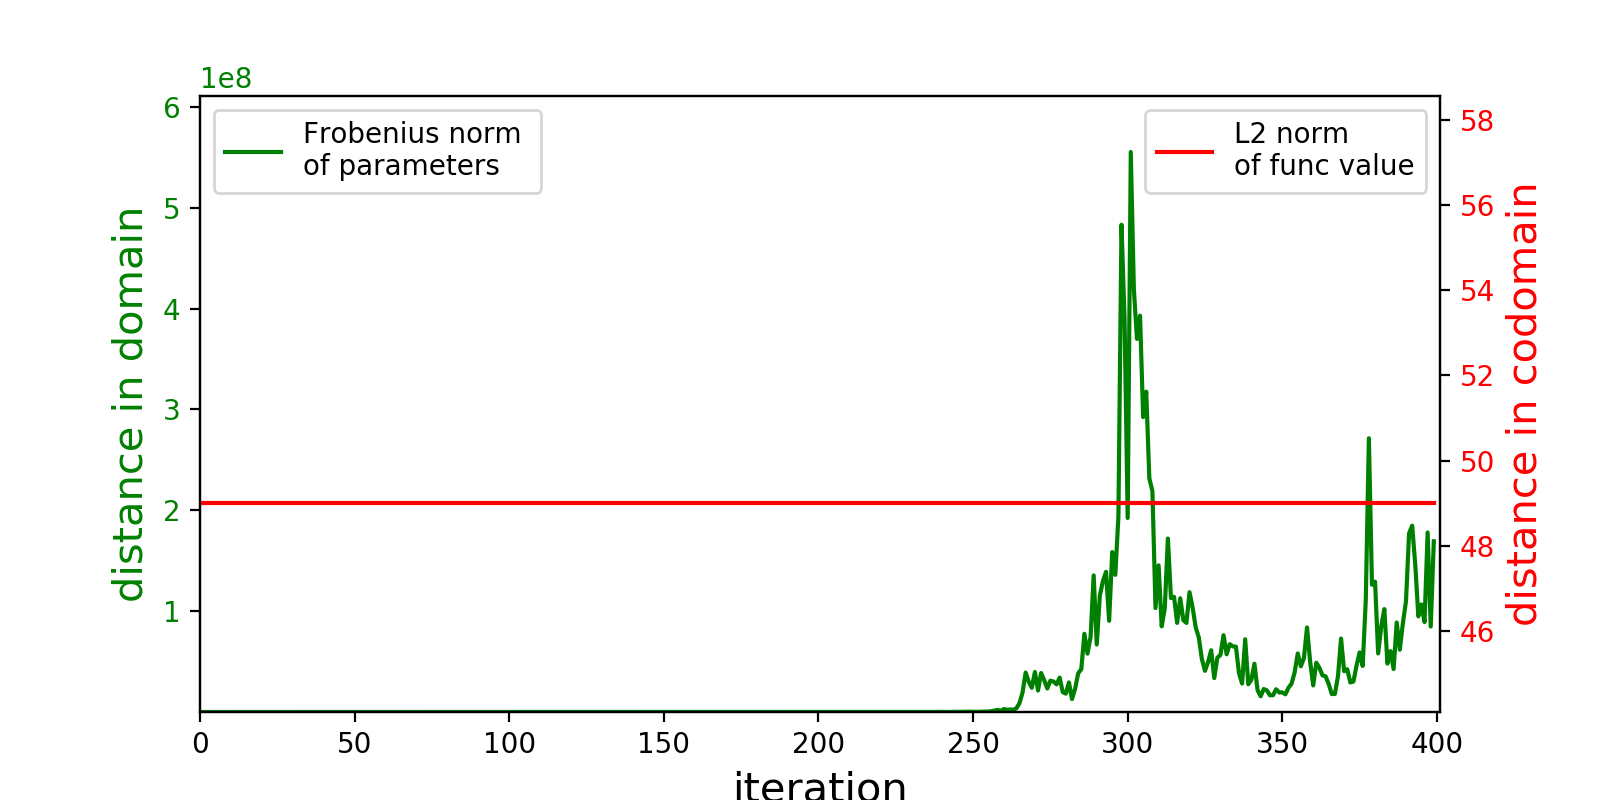

In [337]:
exp2.analyser.plot_distance()

In [338]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
ro = round_off()

# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = ro

cma3 = cma_es()
cma3.set_parameters(paras)

# boil down to one expreiment
exp3 = single_experiment()
exp3.set_objective(ak)
exp3.set_optimise(cma3)
exp3.do()

*******starting optimisation from intitial mean:  [629.193 822.221]
eigenvalue of variance = [9.58907527e-06 1.31470960e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [-2.96874800e+06  1.25934979e+08], found minimum = 20.0
local minimum


In [339]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
l1 = line_search_1step(alpha=1, beta=0.1)

# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = l1

cma4 = cma_es()
cma4.set_parameters(paras)

# boil down to one expreiment
exp4 = single_experiment()
exp4.set_objective(ak)
exp4.set_optimise(cma4)
exp4.do()

*******starting optimisation from intitial mean:  [629.193 822.221]
eigenvalue of variance = [1.33635232e-05 1.79106105e-01]
total iterations = 400, total evaluatios = 14973
found minimum position = [-6.40829816e+04 -4.13741254e+08], found minimum = 20.01558372240338
local minimum


In [ ]:
exp1.analyser.print_points_before_and_after_adjust()

In [ ]:
exp1.analyser.print_evaluations_per_iteration()

In [ ]:
exp1.analyser.print_mean_variance()

In [ ]:
exp1.analyser.plot_distance()

In [ ]:
ana = post_analysis(statistics, ak)

In [ ]:
ana.plot_distance()

In [ ]:
ana.animate_moving_cluster()

In [ ]:
ana.animate_scatterplot_distance()

In [ ]:
ana.plot_moving_cluster()

In [ ]:
    
    def generate_point_cloud(self, sigma, alpha, beta, adjust, points):
        self.num = points.shape[0]
        self.res = np.zeros((self.num, ))
        self.points = points

        for i in range(self.num):
            val, arg, stats = cma_es_general(self.points[i].reshape(2,1), sigma, alpha, beta, adjust, 1e-3, self.func, self.dfunc, self.optimal, self.optimum)
            if(stats['status'] == 'd'):
                self.res[i] = 1
            elif(stats['status'] == 'l'):
                self.res[i] = 0.5
            else:
                self.res[i] = 0

    def plot_prob_vs_radius(self, *args):
        def count_global_min(res, points):        
            distance = np.linalg.norm(points, axis=1)
            idx = np.argsort(distance)
            dis_ascending = distance[idx]
            res_ascending = res[idx]
            prob = np.zeros((self.num, ))
            for i in range(self.num):
                prob[i] = np.sum(res_ascending[:i+1] == 0) / (i + 1) 
            return dis_ascending, prob
        argc = len(args)
        assert argc%2 == 0
        pair_cnt = int(argc / 2)
        dis_ascendings = np.zeros((self.num, pair_cnt + 1))
        probs = np.zeros((self.num, pair_cnt + 1))
        dis_ascendings[:,0], probs[:,0] = count_global_min(self.res, self.points)
        for i in range(pair_cnt):
            dis_ascendings[:,i+1], probs[:,i+1] = count_global_min(args[i*2], args[i*2+1])
        fig = plt.figure(figsize=(8,4))
        ax = fig.add_subplot(1, 1, 1)
        ax.set_xlim(0, np.max(dis_ascendings))
        ax.set_ylim(0, 2)
        ax.set_xlabel('distance from origin', fontsize=13)
        ax.set_ylabel('prob of global minminum', fontsize=13)
        for i in range(pair_cnt+1):
            ax.plot(dis_ascendings[:,i], probs[:,i])
        plt.show()

    def plot_cloud_point(self, other_points=None, other_res=None):
        fig = plt.figure(figsize=(7,7))
        '''
        # one quadrant
        x1 = np.hstack((self.points[:,0], self.points[:,1]))
        y1 = np.hstack((self.points[:,1], self.points[:,0]))
        res1 = np.hstack((self.res, self.res))
        # two qudrant
        x2 = np.hstack((x1, -x1))
        y2 = np.hstack((y1, y1))
        res2 = np.hstack((res1, res1))
        # four qudrant
        x = np.hstack((x2, -x2))
        y = np.hstack((y2, -y2))
        hue = np.hstack((res2, res2))
        '''
        x = self.points[:,0]
        y = self.points[:,1]
        hue = self.res
        p = sns.scatterplot(x=x, y=y, color="r", hue=hue, hue_norm=(0, 1), legend=False)
        if other_points != None and other_res != None:
            x = other_points[:,0]
            y = other_points[:,1]
            hue = other_res
            sns.scatterplot(x=x, y=y, color="r", hue=hue, hue_norm=(0, 1), legend=False)